In [1]:
filename= "Y1-2colo.csv"
import pandas as pd
import numpy as np
import nltk
import re
import string
import codecs

**To transfer dataFrame to a csv file even with non-ascii characters**

In [3]:
df = pd.read_excel('Y1 CVUSD WoW Student Survey V2.xlsx')

In [5]:
df.to_csv('out.csv', sep = '\t', encoding='utf-8')

**Data Preprocessing**

In [2]:
url_pattern = r'((http|https)\S+)' #S= represents all non-space characters until it hits the first space
rt_pattern = r'\brt\b'
name_pattern = r'@\w+'
hashtag_pattern = r'#\w+'

def remove_extra(tweet):
    tweet = re.sub(url_pattern, ' ', tweet)
    tweet = re.sub(r'\d','',tweet)
    tweet = re.sub(rt_pattern,'', tweet)
    tweet = re.sub(name_pattern, '',tweet)
    tweet = re.sub(hashtag_pattern, '',tweet)
    return tweet 

def remove_non_ascii(tweet):
    return ''.join(i for i in tweet if ord(i) < 128)

In [3]:
from nltk.corpus import wordnet as wn
# synonym 同义词
# lemma 词条
def get_lemma(word):
    lemma = wn.morphy(word)
    #利用morphy查找不在wordnet中的词
    if lemma is None:
        return word
    else:
        return lemma

from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

en_stop = set(nltk.corpus.stopwords.words('english'))

In [4]:
#lower, punctuation, token，lemma
def prepare_text_for_lda(text):
    text = text.translate(None,string.punctuation)
    tokens = nltk.word_tokenize(text)
    #tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [12]:
H_male = []
H_female = []

F_male = []
F_female = []
with open(filename) as f:
    for line in f:
        parts = line.split(';')
        if len(parts) == 4:
            #To seperate by FP
            #if parts[0] == 
            #To seperate by gender
            if parts[1] == 'M':
                if len(parts[2]) > 1:
                    H_male.append(parts[2])
                if len(parts[3]) > 1:
                    F_male.append(parts[3])
            if parts[1] == 'F':
                if len(parts[2]) > 1:
                    H_female.append(parts[2])
                if len(parts[3]) > 1:
                    F_female.append(parts[3])
HF = H_male + H_female + F_male + F_female

In [7]:
print len(F_female)

394


In [13]:
def preprocess_data(data_list):
    data = []
    for item in data_list:
        item = item.lower()
        item = remove_non_ascii(item)
        item = remove_extra(item)
        tokens = prepare_text_for_lda(item)
        if len(tokens) > 0:
            data.append(tokens)
    return data
data = preprocess_data(HF)
H_male_data = preprocess_data(H_male)
H_female_data = preprocess_data(H_female)
F_male_data = preprocess_data(F_male)
F_female_data = preprocess_data(F_female)

In [14]:
count = 0
for i in data:
    for j in i:
        count = count + 1
print count

14094


In [15]:
print data[:10]

[[u'practice', 'drawing'], ['yeah'], ['argue', 'alot'], ['better', u'organize', 'things'], ['im', 'traning', 'really', 'hard', 'become', 'really', 'good', 'soccer', 'player'], ['helping', 'construction'], ['tryharding'], ['track', 'right', u'begin', 'training', 'long', 'ago'], ['playing', u'game', 'recording'], ['right', 'im', 'soccer', 'team', u'name', u'hotspur', 'train', u'get', 'keep', 'playing', 'try', 'best', 'make', 'soccer', 'team', 'highschool']]


**LDA topic modeling**

In [37]:
from gensim import corpora
###For H data#####
dictionary = corpora.Dictionary(H_female_data) 
corpus = [dictionary.doc2bow(text) for text in H_female_data]

#######For F data#####
#dictionary = corpora.Dictionary(F_female_data) 
#corpus = [dictionary.doc2bow(text) for text in F_female_data]

###For all data######
#dictionary = corpora.Dictionary(F_data) 
#corpus = [dictionary.doc2bow(text) for text in F_data]

import pickle
pickle.dump(corpus,open('corpus.pkl','wb'))
#dictionary.save('dictionary.gensim')


**Calculate the coherence values**

In [10]:
import gensim

In [38]:
co_list = []
per_list = []
topics_list = []
for i in range(1,21):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics = i, id2word = dictionary, passes =  50)
    per = ldamodel.log_perplexity(corpus)
    per_list.append(per)
    topics_list.append(ldamodel.print_topics(num_words = 10))
    #cohe_ldamodel = gensim.models.CoherenceModel(model = ldamodel, corpus = corpus, coherence = 'u_mass')
    cohe_ldamodel = gensim.models.CoherenceModel(model = ldamodel, texts = data, corpus = corpus, coherence = 'c_v')
    score = cohe_ldamodel.get_coherence()
    co_list.append(score)

In [17]:
print len(co_list)
print co_list

20
[0.1990445288505393, 0.39373986901455515, 0.4135938091901472, 0.42774821787138917, 0.42148622772767697, 0.41150456401724084, 0.4442256867401468, 0.3842244799968032, 0.4016010117037856, 0.3932475303333175, 0.3662413789095394, 0.40046970717578806, 0.38062427370517027, 0.3981687074215155, 0.37040804240318326, 0.39397563732362106, 0.3764551635831892, 0.3899938801513031, 0.3797089334989046, 0.3911999886800628]


In [18]:
print len(per_list)
print per_list

20
[-5.394453375894656, -5.5298201755908085, -5.598874710846737, -5.692161528545552, -5.856379172563881, -5.815529103248962, -5.905554456328773, -5.923746424831369, -5.879584916093199, -5.973526155109016, -6.042132844977414, -5.988661576136671, -6.03020659109041, -6.068359066676908, -6.103349790674176, -6.0749161528578695, -6.08623545393546, -6.090888150298727, -6.138938951468669, -6.148194885437505]


In [19]:
x = []
for i in range(1,21):
    x.append(i)
print x

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


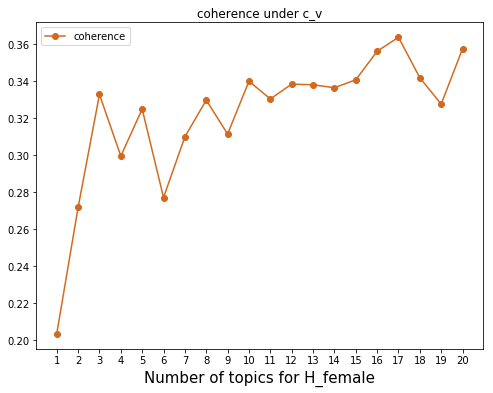

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
plt.figure(figsize=(8,6))

plt.plot(x,co_list, '-or', color = '#D2691E', label = 'coherence')
plt.legend()
#plt.plot(x,per_list, '-or', color = 'steelblue', label = 'coherence')
plt.xlabel('Number of topics for H_female', fontsize = 15)
plt.title('coherence under c_v')
plt.xticks(x)
plt.savefig('coherenceforH_female.png')

In [41]:
print topics_list[2]

[(0, u'0.038*"get" + 0.034*"try" + 0.031*"school" + 0.029*"good" + 0.024*"im" + 0.024*"grade" + 0.018*"hard" + 0.016*"help" + 0.015*"class" + 0.013*"learn"'), (1, u'0.043*"practice" + 0.016*"help" + 0.015*"go" + 0.015*"job" + 0.012*"play" + 0.012*"need" + 0.011*"singing" + 0.011*"know" + 0.010*"learning" + 0.010*"art"'), (2, u'0.020*"im" + 0.017*"learning" + 0.016*"take" + 0.015*"taking" + 0.014*"animal" + 0.013*"also" + 0.012*"make" + 0.011*"care" + 0.010*"people" + 0.010*"get"')]


**Get a counter**

In [8]:
from collections import Counter

In [19]:
def listOfList_to_counter(datas): 
    data_str = []
    for i in datas:
        for j in i:
            data_str.append(j)
    return Counter(data_str)

In [20]:
data_counter = listOfList_to_counter(data)
H_counter = listOfList_to_counter(H_data)
F_counter = listOfList_to_counter(F_data)

In [21]:
data_counter.most_common(20)

[('get', 411),
 ('school', 371),
 ('job', 340),
 ('good', 336),
 (u'try', 308),
 ('im', 307),
 (u'practice', 272),
 (u'grade', 220),
 ('hard', 176),
 ('dont', 175),
 ('getting', 163),
 ('learning', 155),
 ('help', 155),
 ('working', 138),
 ('going', 132),
 ('go', 129),
 ('want', 124),
 ('work', 121),
 ('like', 121),
 ('class', 120)]

In [22]:
H_counter.most_common(20)

[(u'practice', 260),
 ('get', 238),
 ('im', 217),
 ('school', 189),
 (u'try', 180),
 ('good', 158),
 ('help', 139),
 ('learning', 133),
 ('job', 122),
 (u'grade', 109),
 ('play', 107),
 ('class', 98),
 ('going', 86),
 ('hard', 85),
 ('make', 82),
 ('also', 82),
 ('playing', 80),
 ('better', 78),
 ('things', 78),
 ('working', 78)]

In [23]:
F_counter.most_common(20)

[('job', 218),
 ('school', 182),
 ('good', 178),
 ('get', 173),
 ('dont', 152),
 (u'try', 128),
 (u'grade', 111),
 ('hard', 91),
 ('getting', 91),
 ('im', 90),
 ('want', 72),
 ('know', 71),
 ('working', 60),
 ('education', 56),
 ('go', 52),
 ('work', 48),
 ('going', 46),
 ('avoid', 46),
 ('like', 43),
 (u'stay', 35)]